In [ ]:
get_ipython().system('git clone https://bitbucket.org/jadslim/german-traffic-signs')

In [1]:
get_ipython().system('ls german-traffic-signs')

ls: cannot access 'german-traffic-signs': No such file or directory


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import pandas as pd
import random
import cv2
import requests
import PIL
from PIL import Image

In [4]:
print("NumPy Version:", np.__version__)
print("Matplotlib Version:", plt.matplotlib.__version__)
print("TensorFlow Version:", tf.__version__)
print("OpenCV Version:", cv2.__version__)
print("scikit-learn Version:", sklearn.__version__)
print("Pillow Version:", PIL.__version__)

NumPy Version: 1.26.4
Matplotlib Version: 3.8.3
TensorFlow Version: 2.16.1
OpenCV Version: 4.5.5
scikit-learn Version: 1.4.1.post1
Pillow Version: 10.2.0


In [5]:
# Setting the seed for numpy-generated random numbers
np.random.seed(0)

In [6]:
# Loading data
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [8]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0])    , "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0])  , "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3))     , "The dimensions of images are not 32x32x3"
assert(X_val.shape[1:] == (32, 32, 3))       , "The dimensions of images are not 32x32x3"
assert(X_test.shape[1:] == (32, 32, 3))      , "The dimensions of images are not 32x32x3"

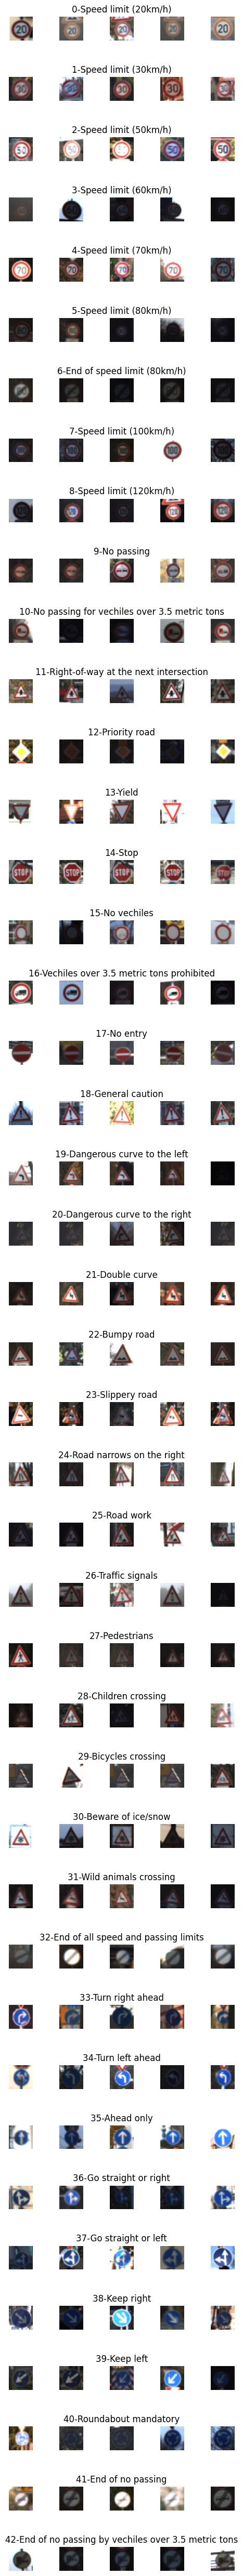

In [9]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + "-" + row["SignName"])
        num_of_samples.append(len(x_selected))


In [10]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.equalizeHist(img)  # Equalize the histogram
    img = img.astype(np.float32) / 255.0  # Convert to float and normalize
    return img

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


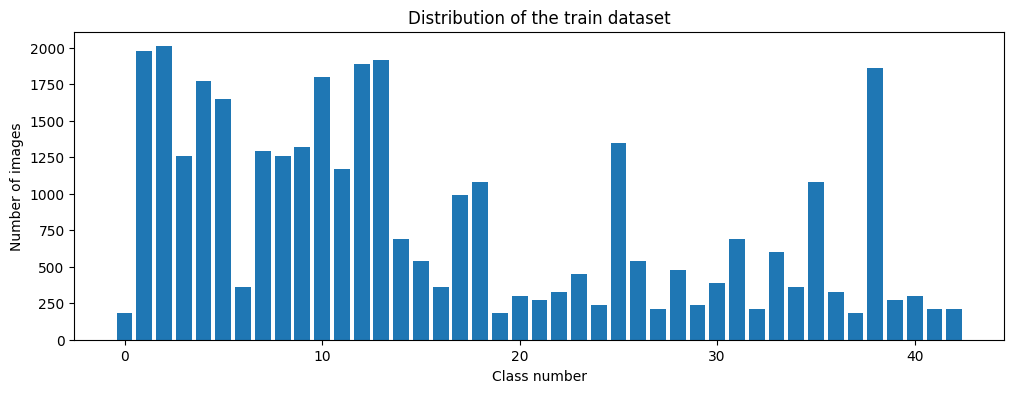

In [11]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


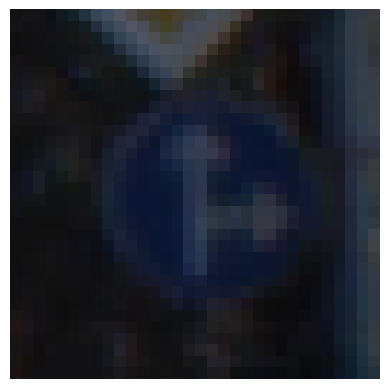

In [12]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


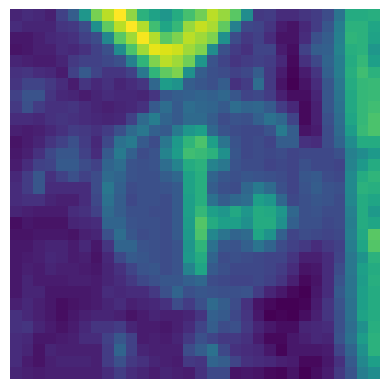

In [13]:
def grayscale(inpImg):
  inpImg = cv2.cvtColor(inpImg, cv2.COLOR_BGR2GRAY)
  return inpImg

gray = grayscale(X_train[1000])

plt.imshow(gray)
plt.axis("off")
print(gray.shape)

(32, 32)


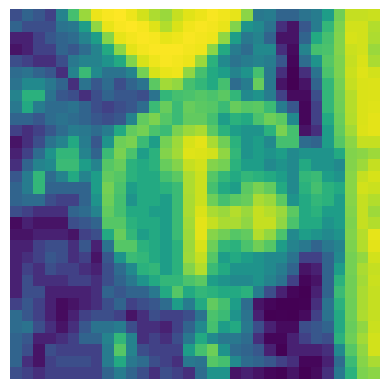

In [14]:
def equalize(inpImage):
  inpImage = cv2.equalizeHist(inpImage)
  return inpImage

equ = equalize(gray)
plt.imshow(equ)
plt.axis("off")
print(gray.shape)

In [15]:
def preprocess(img):
    # Check if image is not already in grayscale
#    if len(img.shape) == 3 and img.shape[2] == 3:
#        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ensure the image is of type uint8 before equalization
    img = img.astype(np.uint8)
    img = cv2.equalizeHist(img)  # Equalize the histogram
    # After equalization, convert to float and normalize
    img = img.astype(np.float32) / 255.0
    return img


(34799, 32, 32, 3)


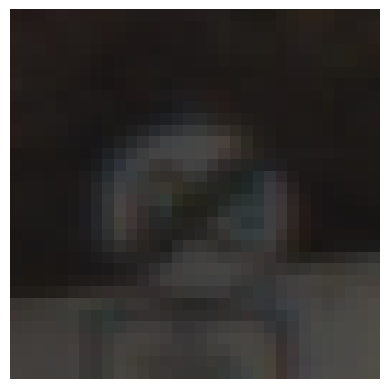

In [16]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [17]:
X_train = np.array(list(map(preprocess, X_train)))
X_val = np.array(list(map(preprocess, X_val)))
X_test = np.array(list(map(preprocess, X_test)))

In [18]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [19]:
# Data augmentation
datagen = ImageDataGenerator(width_shift_range = 0.1,
                   height_shift_range = 0.1,
                   zoom_range = 0.2,
                   shear_range = 0.1,
                   rotation_range = 10)

datagen.fit(X_train)

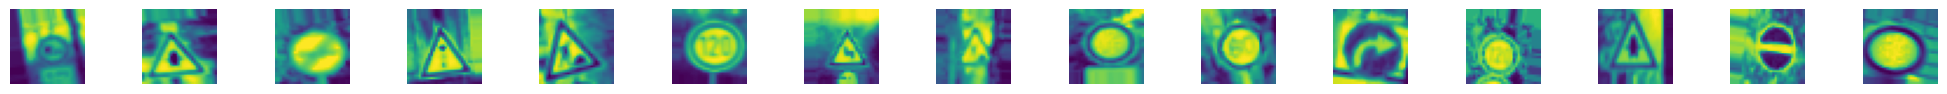

In [20]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [21]:
print(X_train.shape) 
print(X_val.shape) 
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [22]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [23]:
def leNet_model():
    model = Sequential([
        Input(shape=(32, 32, 1)),
        
        Conv2D(60, (5, 5), padding='valid', activation='relu'),
        Conv2D(60, (5, 5), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(30, (3, 3), padding='valid', activation='relu'),
        Conv2D(30, (3, 3), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Dropout(0.5),
        Flatten(),
        Dense(500, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    model.summary()


In [24]:
model = leNet_model()
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
history = model.fit(datagen.flow(X_train, y_train, batch_size = 50), epochs = 37, validation_data = (X_val, y_val), shuffle = 1)

Epoch 1/2


/home/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


696/696 ━━━━━━━━━━━━━━━━━━━━ 156s 222ms/step - accuracy: 0.2205 - loss: 2.8535 - val_accuracy: 0.8667 - val_loss: 0.4254
Epoch 2/2
696/696 ━━━━━━━━━━━━━━━━━━━━ 211s 303ms/step - accuracy: 0.7224 - loss: 0.8952 - val_accuracy: 0.9540 - val_loss: 0.1743


In [ ]:
# Save the trained model
# model.save('new_traffic_signs_model.h5')
model.save('new_traffic_signs_model.keras') # Recommendet

Text(0.5, 0, 'epoch')

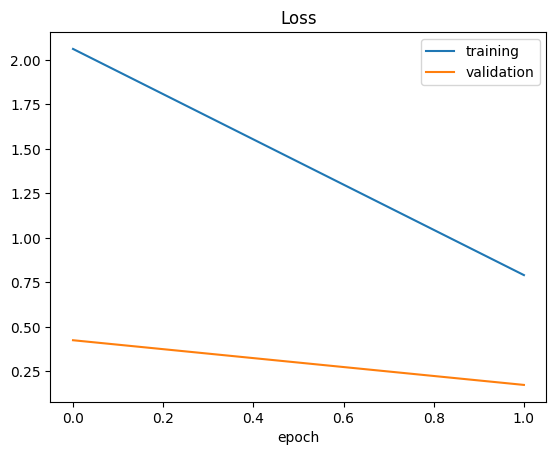

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

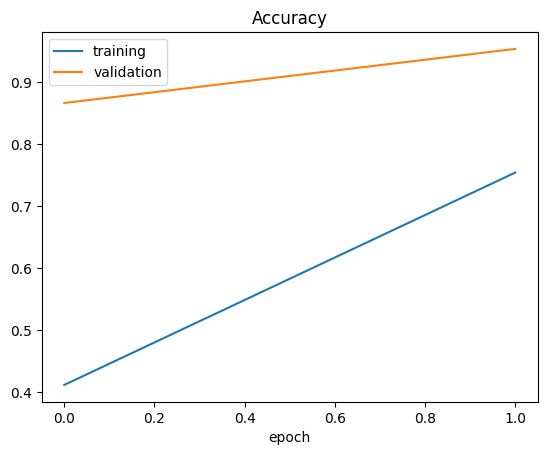

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [39]:
# Mache Vorhersagen auf dem Testset
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step


In [40]:
# Berechne die Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

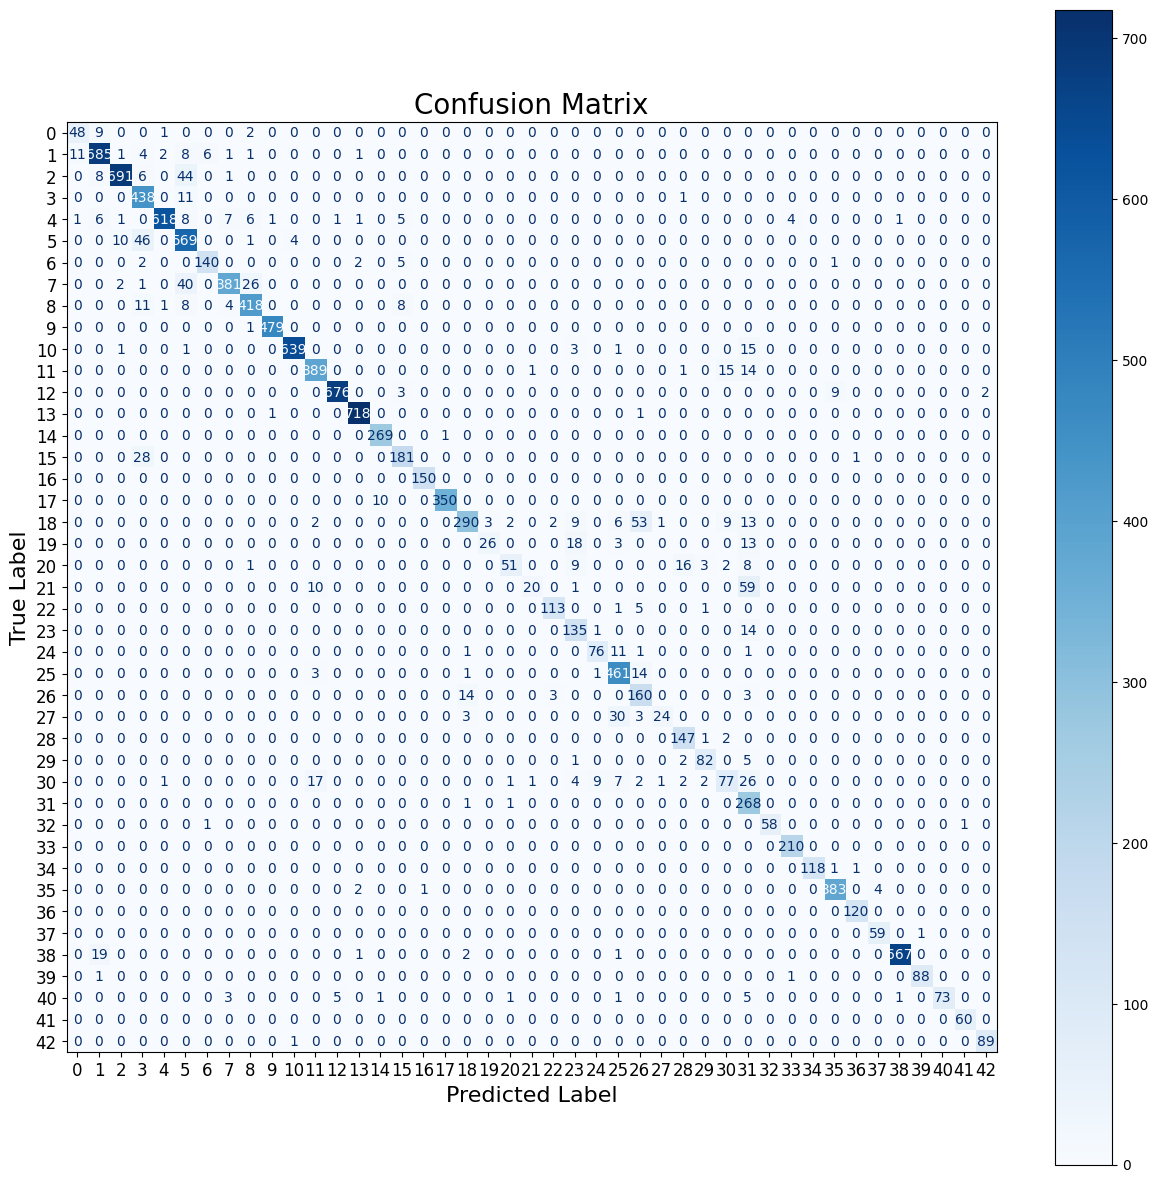

In [45]:
fig, ax = plt.subplots(figsize=(15, 15))  # Größenanpassung für bessere Lesbarkeit
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(43))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='g')
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [46]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.26125597953796387
Test accuracy: 0.9258907437324524


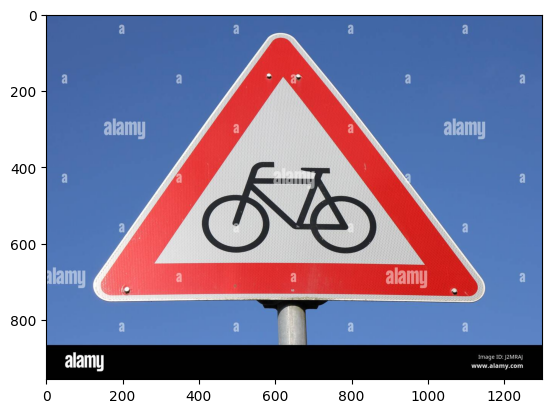

In [47]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


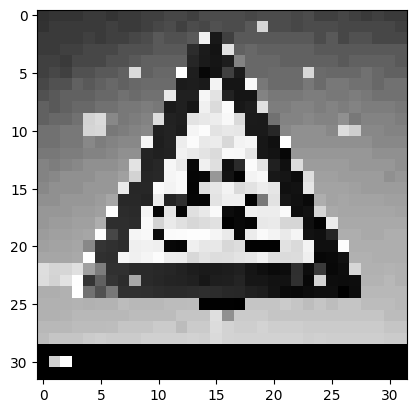

In [48]:
#Preprocess image 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [49]:
img = img.reshape(1, 32, 32, 1)

In [50]:
predictions = model.predict(img)  # Use the correct variable here
predicted_class = np.argmax(predictions, axis=1)
print("Predicted sign: " + str(predicted_class))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted sign: [31]
